# NLP_5 Sentiment Analysis with Scikit-Learn

[Python for NLP: Sentiment Analysis with Scikit-Learn](https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/)

情緒分析(sentiment analysis)是判別文字資料，包括訪問內容、評論等等內容的想法或者情緒狀態。

## Problem Definition

問題：透過推特上對於航空公司的評論，進而去分類該推文對於特定航空公司的情緒，解決流程是要透過監督式學習，利用文字特徵預測出預先分類的情緒類別。

## Solution

首先引進相關的套件和資料集，接著進行 EDA 以對資料有基本認識，再對文字資料進行預處理以轉化成能夠放入機器學習的形式，最後進行模型的訓練和測試。

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
data_source_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)
airline_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## EDA

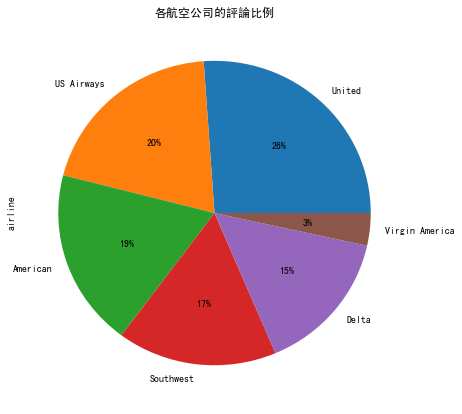

In [14]:
plt.rcParams["figure.figsize"] = [7, 7] # 調整視覺化呈現的長和寬
plt.rcParams['font.sans-serif'] = ['SimHei'] # 設定中文字型

airline_tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')
# autopct 設為 %1.0f%% 百分比會取至整數，%1.1f%% 則會取至小數點第一位

plt.title("各航空公司的評論比例")
plt.show()

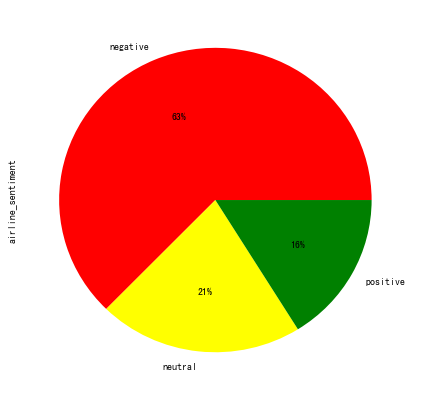

In [11]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])
# 特類情緒的佔比

從圓餅圖中可以看出絕大多數對於航空公司的評論內容都是負面的。

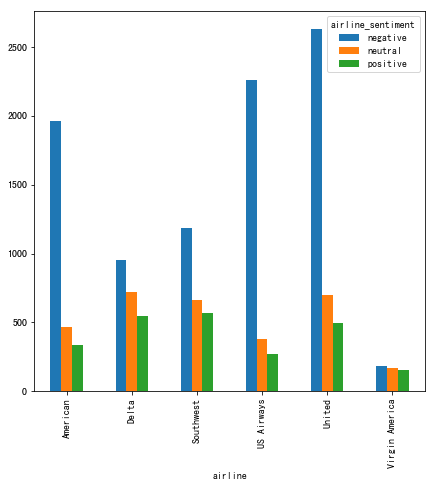

In [10]:
airline_sentiment = airline_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar') # 求各航空公司的情緒分布
# unstack() 可以把分層 series 的資料結構轉為表格，更利於視覺化

從柱狀圖中可以看出大部分的航空公司收到的評論，負面評論的比例都高於其他情緒類別的評論。

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


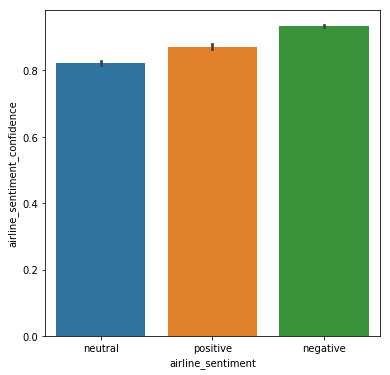

In [59]:
import seaborn as sns

sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence', data=airline_tweets)
# 呈現各情緒的信心水準

從柱狀圖中可以看出，判定為負面情緒評論的信心水準較其他情緒類別高。

## Data Cleaning

對於資料有基本認識之後，接著就是要清理資料以把資料轉化成適合訓練的樣子。首先必須抽取出用來訓練的特徵(features)，在這次的實作中也就是文字資料，且在監督式的機器學習中也必須要有標籤(labels)作為預測的目標，這邊就是情緒的類別資料。

In [3]:
features = airline_tweets.iloc[:, 10].values # 抽出文字資料
labels = airline_tweets.iloc[:, 1].values # 抽出類別資料

在取出文字資料後，接著就要來將它轉化為乾淨一致的格式。具體的過程包括要拿掉特殊符號、拿掉單一字元、重複空白轉成單一空白以及大寫轉小寫，這個過程是為了方便下一步將文字資料轉化成數字資料。

In [27]:
processed_features = []

for sentence in range(0, len(features)):
    # 拿掉特殊字元 '\W'
    processed_feature = re.sub('\W', ' ', str(features[sentence]))

    # 拿掉單一字元的詞
    processed_feature= re.sub('\s+[a-zA-Z]\s+', ' ', processed_feature)

    # 拿掉開頭單一字元詞
    processed_feature = re.sub('\^[a-zA-Z]\s+', ' ', processed_feature) 

    # 將重複空白轉為單一空白
    processed_feature = re.sub('\s+', ' ', processed_feature)

    # 全部字母轉為小寫
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

## Representing Text in Numeric Form

In [28]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [30]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [31]:
predictions = text_classifier.predict(X_test)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[1723  108   39]
 [ 326  248   40]
 [ 132   58  254]]
             precision    recall  f1-score   support

   negative       0.79      0.92      0.85      1870
    neutral       0.60      0.40      0.48       614
   positive       0.76      0.57      0.65       444

avg / total       0.75      0.76      0.74      2928

0.7599043715846995
